# Summary of time taken and brier scores for jaxlogit, xlogit, and biogeme
Where the estimation is using draws = 600 (suboptimal but highest without running out of memory in biogeme), and training and test data is separated.

| | jaxlogit | xlogit | biogeme |
|---|---|---|---|
|Making Model | 37.7s | 16.9s | 4:15 |
|Estimating | 1.6s | 0.0s | 15.4s |
|Brier Score | 0.6345 | 0.6345 | 0.6345 |

# Setup

In [2]:
import os
os.chdir("/home/evelyn/projects_shared/jaxlogit")

import pandas as pd
import numpy as np
import jax
import pathlib
import xlogit
from time import time

from jaxlogit.mixed_logit import MixedLogit, ConfigData

import biogeme.biogeme_logging as blog
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Draws, log, MonteCarlo, PanelLikelihoodTrajectory
import biogeme.database as db
from biogeme.expressions import Variable

logger = blog.get_screen_logger()
logger.setLevel(blog.INFO)

#  64bit precision
jax.config.update("jax_enable_x64", True)

os.chdir("/home/evelyn/projects_shared/jaxlogit/examples/graphs")

# Get the full electricity dataset

Use for jaxlogit and xlogit. Adjustusting n_draws can improve accuracy, but Biogeme cannot handle 700 or more draws with this data set.

In [3]:
varnames = ['pf', 'cl', 'loc', 'wk', 'tod', 'seas']
quick_draws_biogeme = [100, 200, 400, 500, 600]
quick_draws_extended = [700, 800, 900, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

In [4]:
rdf_fit = pd.DataFrame(columns=["package", "draws", "time"])
rdf_predict = pd.DataFrame(columns=["package", "time"])

Reshape the data so it can be passed to test_train_split in a wide format. Additionally, xlogit and jaxlogit require long format while biogeme requires a wide format.

In [5]:
df_long = pd.read_csv(pathlib.Path.cwd().parent.parent / "examples" / "electricity_long.csv")
choice_df = df_long.loc[df_long['choice'] == 1, ['id', 'chid', 'alt']]
choice_df = choice_df.rename(columns={'alt': 'choice'})
df_wide = df_long.pivot(index=['id', 'chid'], columns='alt', values=varnames)
df_wide.columns = [f'{var}_{alt}' for var, alt in df_wide.columns]
df_wide = df_wide.reset_index()
df_wide = df_wide.merge(
    choice_df,
    on=['id', 'chid'],
    how='inner',
    validate='one_to_one'
)

database_panel = db.Database('electricity', df_wide)
database_panel.panel('id')
database = db.Database('electricity', df_wide)

y = df_long['choice']
ids = df_long['chid']
alts = df_long['alt']
panels = df_long['id']

In [6]:
randvars = {'pf': 'n', 'cl': 'n', 'loc': 'n', 'wk': 'n', 'tod': 'n', 'seas': 'n'}

model_jax_scipy_batched = MixedLogit()
model_jax_scipy = MixedLogit()
model_jax_scipy_l = MixedLogit()
model_jax_optax = MixedLogit()
model_jax_optax_batched = MixedLogit()
model_jax_jax_batched = MixedLogit()
model_jax_jax = MixedLogit()
model_jax_jax_l = MixedLogit()
model_x = xlogit.MixedLogit()

init_coeff = None

Biogeme setup:

In [7]:
X = {
    name: {
        j: Variable(f"{name}_{j}")
        for j in [1,2,3,4]
    }
    for name in varnames
}

alt_1 = Beta('alt_1', 0, None, None, 0)
alt_2 = Beta('alt_2', 0, None, None, 0)
alt_3 = Beta('alt_3', 0, None, None, 0)
alt_4 = Beta('alt_4', 0, None, None, 1)

pf_mean = Beta('pf_mean', 0, None, None, 0)
pf_sd = Beta('pf_sd', 1, None, None, 0)
cl_mean = Beta('cl_mean', 0, None, None, 0)
cl_sd = Beta('cl_sd', 1, None, None, 0)
loc_mean = Beta('loc_mean', 0, None, None, 0)
loc_sd = Beta('loc_sd', 1, None, None, 0)
wk_mean = Beta('wk_mean', 0, None, None, 0)
wk_sd = Beta('wk_sd', 1, None, None, 0)
tod_mean = Beta('tod_mean', 0, None, None, 0)
tod_sd = Beta('tod_sd', 1, None, None, 0)
seas_mean = Beta('seas_mean', 0, None, None, 0)
seas_sd = Beta('seas_sd', 1, None, None, 0)

pf_rnd = pf_mean + pf_sd * Draws('pf_rnd', 'NORMAL')
cl_rnd = cl_mean + cl_sd * Draws('cl_rnd', 'NORMAL')
loc_rnd = loc_mean + loc_sd * Draws('loc_rnd', 'NORMAL')
wk_rnd = wk_mean + wk_sd * Draws('wk_rnd', 'NORMAL')
tod_rnd = tod_mean + tod_sd * Draws('tod_rnd', 'NORMAL')
seas_rnd = seas_mean + seas_sd * Draws('seas_rnd', 'NORMAL')

choice = Variable('choice')

V = {
    j: pf_rnd * X['pf'][j] + cl_rnd * X['cl'][j] + loc_rnd * X['loc'][j] + wk_rnd * X['wk'][j] + tod_rnd * X['tod'][j] + seas_rnd * X['seas'][j]
    for j in [1,2,3,4]
}

# Make the models
Jaxlogit:

In [8]:
combos = [('jaxlogit_scipy', "L-BFGS-B-scipy"), ('jaxlogit_scipy_b', "BFGS-scipy"), ('jaxlogit_jax', "L-BFGS-jax"), ('jaxlogit_jax_b', "BFGS-jax")]
combos_batched = [('jaxlogit_scipy_batched', "L-BFGS-B-scipy"), ('jaxlogit_scipy_b_batched', "BFGS-scipy")]

In [9]:
for (name, method) in combos:
    print("Using " + str(name))
    for draw in (quick_draws_biogeme + quick_draws_extended):
        model_jax = MixedLogit()
        print("starting " + str(draw))
        start_time = time()
        config = ConfigData(
            panels=panels,
            n_draws=draw,
            skip_std_errs=True,  # skip standard errors to speed up the example
            batch_size=None,
            optim_method=method,
        )
        init_coeff = None
        
        model_jax.fit(
            X=df_long[varnames],
            y=df_long['choice'],
            varnames=varnames,
            ids=df_long['chid'],
            alts=df_long['alt'],
            randvars={'pf': 'n', 'cl': 'n', 'loc': 'n', 'wk': 'n', 'tod': 'n', 'seas': 'n'},
            config=config
        )
        ellapsed = time() - start_time
        rdf_fit.loc[len(rdf_fit)] = [name, draw, ellapsed]

Using jaxlogit_scipy
starting 100
starting 200
starting 400
starting 500
starting 600
starting 700
starting 800
starting 900
starting 1000
starting 1500
starting 2000
starting 2500
starting 3000
starting 4000
starting 5000
Using jaxlogit_scipy_b
starting 100


**** The optimization did not converge after 34 iterations. ****


starting 200


**** The optimization did not converge after 34 iterations. ****


starting 400
starting 500


**** The optimization did not converge after 31 iterations. ****


starting 600
starting 700


**** The optimization did not converge after 33 iterations. ****


starting 800
starting 900
starting 1000
starting 1500


**** The optimization did not converge after 40 iterations. ****


starting 2000
starting 2500


**** The optimization did not converge after 49 iterations. ****


starting 3000
starting 4000


**** The optimization did not converge after 46 iterations. ****


starting 5000


**** The optimization did not converge after 35 iterations. ****


Using jaxlogit_jax
starting 100


**** The optimization did not converge after 144 iterations. ****


starting 200


**** The optimization did not converge after 38 iterations. ****


starting 400


**** The optimization did not converge after 33 iterations. ****


starting 500


**** The optimization did not converge after 89 iterations. ****


starting 600


**** The optimization did not converge after 38 iterations. ****


starting 700


**** The optimization did not converge after 3 iterations. ****


starting 800


**** The optimization did not converge after 2 iterations. ****


starting 900


**** The optimization did not converge after 5 iterations. ****


starting 1000


**** The optimization did not converge after 44 iterations. ****


starting 1500


**** The optimization did not converge after 54 iterations. ****


starting 2000


**** The optimization did not converge after 2 iterations. ****


starting 2500


**** The optimization did not converge after 38 iterations. ****


starting 3000


**** The optimization did not converge after 63 iterations. ****


starting 4000


**** The optimization did not converge after 25 iterations. ****


starting 5000


**** The optimization did not converge after 25 iterations. ****


Using jaxlogit_jax_b
starting 100
starting 200


**** The optimization did not converge after 37 iterations. ****


starting 400


**** The optimization did not converge after 71 iterations. ****


starting 500


**** The optimization did not converge after 2 iterations. ****


starting 600


**** The optimization did not converge after 3 iterations. ****


starting 700


**** The optimization did not converge after 9 iterations. ****


starting 800


**** The optimization did not converge after 31 iterations. ****


starting 900


**** The optimization did not converge after 20 iterations. ****


starting 1000


**** The optimization did not converge after 2 iterations. ****


starting 1500


**** The optimization did not converge after 37 iterations. ****


starting 2000


**** The optimization did not converge after 10 iterations. ****


starting 2500


**** The optimization did not converge after 2 iterations. ****


starting 3000


**** The optimization did not converge after 3 iterations. ****


starting 4000


**** The optimization did not converge after 2 iterations. ****


starting 5000


**** The optimization did not converge after 34 iterations. ****


In [10]:
for (name, method) in combos_batched:
    for draw in (quick_draws_biogeme + quick_draws_extended):
        model_jax = MixedLogit()
        print("starting " + str(draw))
        start_time = time()
        config = ConfigData(
            panels=panels,
            n_draws=draw,
            skip_std_errs=True,  # skip standard errors to speed up the example
            batch_size=539,
            optim_method=method,
        )
        init_coeff = None
        
        model_jax.fit(
            X=df_long[varnames],
            y=df_long['choice'],
            varnames=varnames,
            ids=df_long['chid'],
            alts=df_long['alt'],
            randvars={'pf': 'n', 'cl': 'n', 'loc': 'n', 'wk': 'n', 'tod': 'n', 'seas': 'n'},
            config=config
        )
        ellapsed = time() - start_time
        rdf_fit.loc[len(rdf_fit)] = [name, draw, ellapsed]

starting 100
starting 200
starting 400
starting 500
starting 600
starting 700
starting 800
starting 900
starting 1000
starting 1500
starting 2000
starting 2500
starting 3000
starting 4000
starting 5000
starting 100
starting 200


**** The optimization did not converge after 34 iterations. ****


starting 400
starting 500


**** The optimization did not converge after 32 iterations. ****


starting 600
starting 700


**** The optimization did not converge after 33 iterations. ****


starting 800
starting 900
starting 1000
starting 1500
starting 2000
starting 2500
starting 3000
starting 4000


**** The optimization did not converge after 47 iterations. ****


starting 5000


**** The optimization did not converge after 34 iterations. ****


xlogit:

In [ ]:
for draw in (quick_draws_biogeme + quick_draws_extended):
    start_time = time()
    model_x.fit(
        X=df_long[varnames],
        y=y,
        varnames=varnames,
        ids=ids,
        alts=alts,
        randvars=randvars,
        panels=panels,
        n_draws=draw,
        skip_std_errs=True,  # skip standard errors to speed up the example
        batch_size=None,
        optim_method="L-BFGS-B-scipy",
    )
    ellapsed = time() - start_time
    rdf_fit.loc[len(rdf_fit)] = ['xlogit', draw, ellapsed]
init_coeff_x = model_x.coeff_

Biogeme:

In [12]:
for draw in quick_draws_biogeme:
    print(f"starting draw {draw}")
    start_time = time()
    prob = models.logit(V, None, choice)
    logprob = log(MonteCarlo(PanelLikelihoodTrajectory(prob)))

    the_biogeme = bio.BIOGEME(
        database_panel, logprob, number_of_draws=draw, seed=999, generate_yaml=False, generate_html=False
    )
    the_biogeme.model_name = 'model_b'
    results = the_biogeme.estimate()
    ellapsed = time() - start_time
    rdf_fit.loc[len(rdf_fit)] = ['biogeme', draw, ellapsed]

starting draw 100


File biogeme.toml has been created 
File biogeme.toml has been created 
The number of draws (100) is low. The results may not be meaningful. 
The number of draws (100) is low. The results may not be meaningful. 


starting draw 200


The number of draws (200) is low. The results may not be meaningful. 
The number of draws (200) is low. The results may not be meaningful. 


starting draw 400


The number of draws (400) is low. The results may not be meaningful. 
The number of draws (400) is low. The results may not be meaningful. 


starting draw 500


The number of draws (500) is low. The results may not be meaningful. 
The number of draws (500) is low. The results may not be meaningful. 


starting draw 600


The number of draws (600) is low. The results may not be meaningful. 
The number of draws (600) is low. The results may not be meaningful. 


# Graphs

In [19]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14,
                            'axes.spines.right': False,
                            'axes.spines.top': False})
libs = ['jaxlogit_scipy', 'jaxlogit_scipy_b', 'jaxlogit_jax', 'jaxlogit_jax_b','xlogit', 'biogeme']

In [ ]:
import json

# # Dump all of rdf_fit
# list = rdf_fit.values.tolist()
# with open("comparison_data_fit.json", "w") as f:
#     json.dump(list, f)

# Retrieve all of rdf_fit
# with open("comparison_data_fit.json", "r") as f:
#     fit_data = json.load(f)
# rdf = pd.DataFrame(fit_data)
# rdf.columns = ["package", "draws", "time"]
# rdf = pd.concat([rdf, rdf_fit], ignore_index=True)

# # print(rdf_fit)

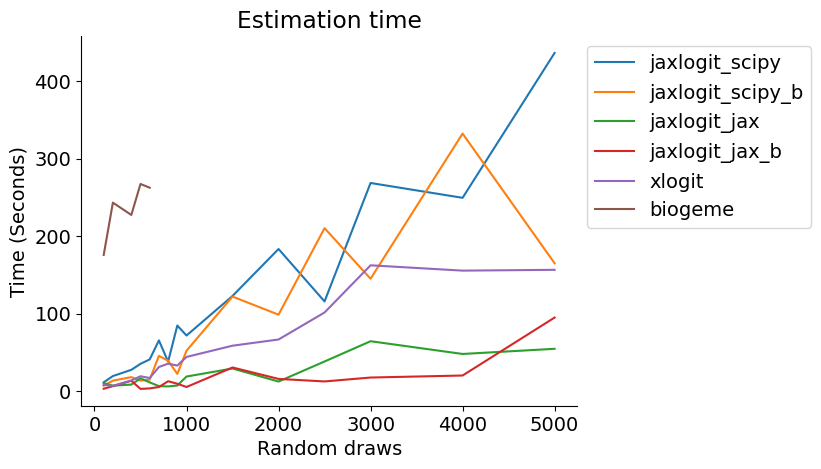

In [21]:
def plot(df, name):
    for lib in libs:
        rdf = df.loc[df["package"] == lib]
        plt.plot(rdf["draws"], rdf["time"], label=lib)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Random draws")
    plt.ylabel("Time (Seconds)")
    plt.title("Estimation time")
    plt.savefig(name)
    plt.show()
    plt.close()

plot(rdf_fit, "fit_estimation_time")

# def bar(df, name):
#     plt.bar(libs, df["time"], color=colors.values())
#     plt.xlabel("Package")
#     plt.ylabel("Time (Seconds)")
#     plt.title("Predict time")
#     plt.savefig(name)

# bar(rdf_predict, "predict_time")